In [325]:
from IPython.core.display import HTML

display(HTML("<style>.container { width:calc(100% - 350px) !important; } body { height:100% !important; }</style>"))

# The company

<img src="rossmann.jpg" alt="Rossmann logo" width="300">
Rossmann its one of the largest drug store chains in Europe with around 56k employers and more than 4000 stores.
The product range includes around 22k items and can vary depending of the size of the shop and the location. 
In addition to drugstore products with a focus on skin, hair, body, baby and health, Rossmann also offers others items like pet food, photo service and a large range of natural foods and wine.  
(last update 2019)

# Business Problem

What is the store sales prediction for the next six month?

The CEO has difficulty defining the amount of money to invest in renovating some stores.
Talking to the CEO, he explained that knowing the total sales for each store for the next six months, he would be able to define whether or not to invest in renovations.
Understanding that the solution suggested by the CEO seems to solve your problem. It was proposed the development of a machine learning algorithm with the objective of predicting the revenue of each store for the next six weeks.

# Correlation Hypotheses

What could correlate (interfere) with the total sales in each store?
<img src="hipotesis.png" alt="Rossmann logo" width="100%">

## Time

- There is a seasonality in the volume of the sales (general business knowledge)
- More sales are made on holidays (general perception of the sales team)  
- More sales are made on promotions day (general perception of the sales team)

## Products

- Products on sale sell more
- Prices do not determine the volume of sales of a given product
- Products with active marketing campaigns sell more
- Products with more exhibition sell more
- Products with stock sell more

## Localization

- Proximity to related businesses increases sales
- Stores located in populated areas sell more
- The total sales pattern changes by country

## Stores

- Stores with a greater variety of products sell more
- Bigger stores sell more
- Stores with close competitors sell less

## Clients

- O total que o cliente já comprou na rede tem relação com o seu padrao de compra
- Clientes com mais filhos compram mais
- Clientes com salários maiores compram mais
- A idade impacta no volume gasto pelos cliente
- A profissão impacta no volume gasto pelo cliente
- Se o cliente tem família ele gasta mais
- Clientes com maior frequencia de compras tendem a gastar mais

# Data Collect

According to the hypotheses above, the following list of data to be collected was raised:
- Daily sales amount
- Data
- There is a holiday? Which One?
- Is it a promotional day? Which One?
- The products selled on that day with:
  - Its price
  - If was on sale
  - If there was a marketing campaign
  - If it was exhibited
  - The stock
- The proximity of the store with related business
- Kind of area the store is located (country/city)
- Country where the store is located
- Variety of products of the store
- Size (area) of the store
- Proximity with competitors

As this is a fictitious project carried out using data provided by Rossmann.  
The data collection step is summarized in picking up the datasets available at the link below:  
https://www.kaggle.com/competitions/rossmann-store-sales/data  
Hypotheses that depend on features that are not in the dataset will be automatically discarded.

# Libraries

## Installs

In [12]:
!pip install inflection

## Imports

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection

## Functions

In [2]:
# I'm going to create a lib for it
import inspect
from IPython.display import clear_output

class Tracker: 
    def __init__(self, data=None):
        self.last_process_consolidated = -1
        self.processes = []
        self.backups = {}
        self.data = data
        if self.data is not None:
            self.backups[-1] = self.data
        
    def get_last_backup_id(self, older_than=float('inf')):
        last_backup_id = max([key for key in self.backups.keys() if key < older_than])
        return last_backup_id
    
    def get_process_id(self, column, action):
        for _id, process in enumerate(self.processes):
            if (process['column'] == column) and (process['action'] == action):
                return _id                
        return None
    
    def is_same_function(self, _id, function):
        return inspect.getsource(function) == inspect.getsource(self.processes[_id]['function'])
    
    def purge_backups(self, newer_than=0):
        self.backups = {key: value for key, value in self.backups.items() if key <= newer_than}
        return None
    
    def rolback_consolidation(self, backup_id):
        self.last_process_consolidated, self.data = backup_id, self.backups[backup_id].copy()
        self.purge_backups(backup_id)   
        for _id, process in enumerate(self.processes):
            if _id > backup_id:
                process['consolidated'] = False
            
    def consolidate(self, until_process=float('inf')):
        if self.data is not None:
            last_process = len(self.processes) - 1
            until_process = min(until_process, last_process)         
            proccesses_list = range(self.last_process_consolidated + 1 ,until_process + 1)
            if len(proccesses_list) > 1:
                answer = input('More than 1 process to consolidate. Do you want to continue? [Y to continue]')
                clear_output()
                if answer != 'Y':       
                    print('Preprocessing data not consolidated.')
                    return None
            for _id in proccesses_list:
                self.data = self.processes[_id]['function'](self.data)
                self.processes[_id]['consolidated'] = True
                self.last_process_consolidated = _id 
        return None

    def track(self, column='_general_', action='_general_', function=lambda data: data, description='_general_'):
        process = {'column': column, 
                   'action': action, 
                   'function': function, 
                   'description': description,
                   'consolidated': False}
        process_id = self.get_process_id(column, action)      
        if process_id is None:
            self.processes.append(process)
            self.consolidate()
        else:
            if (self.data is not None) and self.processes[process_id]['consolidated']:
                if self.is_same_function(process_id, function):
                    process['consolidated'] = self.processes[process_id]['consolidated']
                else:
                    last_backup_id = self.get_last_backup_id(process_id)
                    answer = input(f'''Process  [{process_id} | {column} | {action}] already exists with another function.
If you continue, the consolidating of the data will be returned to the process {last_backup_id} (last consolidated backup).
All processes after this one must be re-executed.
Do you want continue? [Y to continue] :''')
                    clear_output()
                    if answer != 'Y':
                        print('Tracking aborted.')
                        return None
                    self.rolback_consolidation(last_backup_id)        
                    
            self.processes[process_id] = process
            self.consolidate(process_id)
        #print(description)
        return None
    
    def set_process_order(self, column, action, new_order, consolidate=True):
        process_id = self.get_process_id(column, action)
        last_consolidated_id = min(process_id, new_order) - 1
        last_backup_id = self.get_last_backup_id(last_consolidated_id)
        self.rolback_consolidation(last_backup_id)
        process = self.processes.pop(process_id)
        self.processes.insert(new_order, process)
        if consolidate:
            self.consolidate()
        return None    
    
    def status(self):
        status = ' flag | id - column - action - description \n'
        for _id, process in enumerate(self.processes):
            consolidated_flag = '>>' if _id == self.last_process_consolidated else '  '
            backup_flag = 'b' if self.backups.get(_id) is not None else ' '
            status += f" {consolidated_flag} {backup_flag} | {_id} - {process['column']} - {process['action']} - {process['description']}\n"
        status += '\n[>>: last consolidated | b: backed up]'
        print(status)
        return None
    
    def backup(self):
        if self.data is not None:
            self.backups[self.last_process_consolidated] = self.data.copy()
            print(f'Created backup of data with processes executed up to process {self.last_process_consolidated}')
        else:
            print('Impossible to backup. The preprocessing instance contains no data')
        return None
    
    def view_processes(self):
        processes_list = ''
        for process in self.processes:
            processes_list += f"('{process['column']}', '{process['action']}'), # {process['description']}" + '\n'
        print(processes_list)
        return None
        
    def process(self, data): 
        for process in self.processes:
            data = process['function'](data)
        return data

# Data Loading

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [4]:
df_raw = df_sales_raw.merge(df_stores_raw, how='left', on='Store')
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
134432,633,4,2015-04-02,9488,716,1,1,0,1,d,a,11640.0,4.0,2005.0,1,22.0,2011.0,"Jan,Apr,Jul,Oct"
527888,164,6,2014-03-15,4160,424,1,0,0,0,a,a,1160.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
384308,244,6,2014-07-26,3266,461,1,0,0,0,d,a,710.0,3.0,2012.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
386449,561,4,2014-07-24,5137,592,1,0,0,1,d,a,14300.0,NaN,NaN,0,NaN,NaN,NaN
431665,946,2,2014-06-10,4318,573,1,0,0,0,a,a,2220.0,12.0,2011.0,1,14.0,2015.0,"Jan,Apr,Jul,Oct"


# Initial Data Description

In [5]:
df_idd = pd.DataFrame()
df_idd.index = df_raw.columns
df_idd['column'] = df_raw.columns
df_idd.loc['Store', 'description'] = 'a unique Id for each store'  
df_idd.loc['DayOfWeek', 'description'] = 'day of week'  
df_idd.loc['Date', 'description'] = 'data'  
df_idd.loc['Sales', 'description'] = 'the turnover for any given day (this is what you are predicting)'  
df_idd.loc['Customers', 'description'] = 'the number of customers on a given day'
df_idd.loc['Open', 'description'] = 'an indicator for whether the store was open: 0 = closed, 1 = open'
df_idd.loc['Promo', 'description'] = 'indicates whether a store is running a promo on that day'
df_idd.loc['StateHoliday', 'description'] = ' indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None'
df_idd.loc['SchoolHoliday', 'description'] = 'indicates if the (Store, Date) was affected by the closure of public schools'
df_idd.loc['StoreType', 'description'] = 'differentiates between 4 different store models: a, b, c, d'
df_idd.loc['Assortment', 'description'] = 'describes an assortment level: a = basic, b = extra, c = extended'  
df_idd.loc['CompetitionDistance', 'description'] = 'distance in meters to the nearest competitor store'
df_idd.loc['CompetitionOpenSinceMonth', 'description'] = 'gives the approximate year and month of the time the nearest competitor was opened'
df_idd.loc['CompetitionOpenSinceYear', 'description'] = 'gives the approximate year and month of the time the nearest competitor was opened'
df_idd.loc['Promo2', 'description'] = 'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating'
df_idd.loc['Promo2SinceWeek', 'description'] = 'describes the year and calendar week when the store started participating in Promo2'
df_idd.loc['Promo2SinceYear', 'description'] = 'describes the year and calendar week when the store started participating in Promo2'
df_idd.loc['PromoInterval', 'description'] = 'describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store'

In [6]:
df_idd['dtype'] = df_raw.dtypes

In [7]:
df_idd['NAs'] = df_raw.isna().sum()

In [8]:
df_idd['uniques'] = df_raw.nunique()

In [9]:
print(f'df_raw contains {df_raw.shape[0]} lines with {df_raw.shape[1]} columns each')
df_idd_styled = (df_idd.style.set_properties(subset=['column', 'description'], **{'text-align': 'left'})
                             .set_properties(subset=['dtype', 'NAs', 'uniques'], **{'text-align': 'center'})
                             .set_table_styles([{'selector': 'th', 
                                                 'props': [('text-align', 'left')]}])
                             .hide(axis='index'))
df_idd_styled

df_raw contains 1017209 lines with 18 columns each


column,description,dtype,NAs,uniques
Store,a unique Id for each store,int64,0,1115
DayOfWeek,day of week,int64,0,7
Date,data,object,0,942
Sales,the turnover for any given day (this is what you are predicting),int64,0,21734
Customers,the number of customers on a given day,int64,0,4086
Open,"an indicator for whether the store was open: 0 = closed, 1 = open",int64,0,2
Promo,indicates whether a store is running a promo on that day,int64,0,2
StateHoliday,"indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None",object,0,4
SchoolHoliday,"indicates if the (Store, Date) was affected by the closure of public schools",int64,0,2
StoreType,"differentiates between 4 different store models: a, b, c, d",object,0,4


# Data Exploration & Preparation (DE&P)

In [10]:
tracker = Tracker(df_raw.copy())

## All Columns

### Rename

In [14]:
def rename_all_columns(data):
    old_names = data.columns
    new_names = list(map(inflection.underscore, old_names))
    data.columns = new_names
    return data

tracker.track('_general_', 'rename', rename_all_columns, 'Rename all columns to snake_case')

print('Renamed all columns to snake_case pattern')

Renamed all columns to snake_case pattern


## sales

### #1 Univariated Analysis

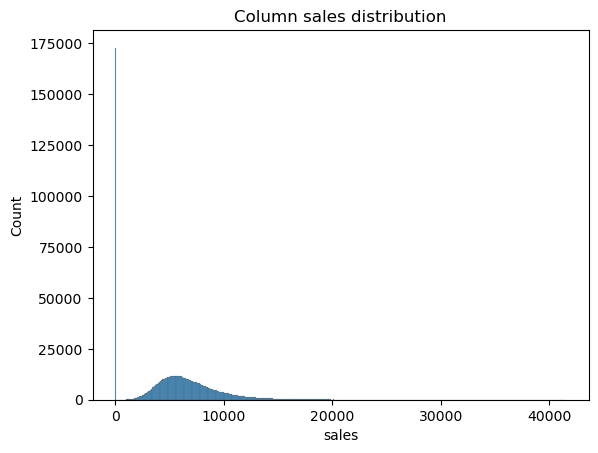

In [21]:
data = tracker.data.copy()

sns.histplot(data['sales']);
plt.title('Column sales distribution');

In [22]:
print('''There are a lot of rows with sales equal to 0. 
It is interesting to drop the lines with 0 values to consider them as NA values.''')

There are a lot of rows with sales equal to 0. 
It is interesting to drop the lines with 0 values to consider them as NA values.


### Type

In [24]:
data = tracker.data.copy()
if data['sales'].dtype == 'int64':
    print("Column sales has the right type: int64.")
else:
    print('Please check here.')

Column sales has the right type: int64.


### NAs

In [25]:
def treatNA_sales(data):
    data = data[(~data['sales'].isna()) & (data['sales'] != 0)]
    return data

tracker.track('sales', 'treatNA', treatNA_sales, 'Drop lines with NAs or 0 values to sales')

print('Droped lines with sales equal to 0. ')

Droped lines with sales equal to 0. 


### #2 Univariated Analysis

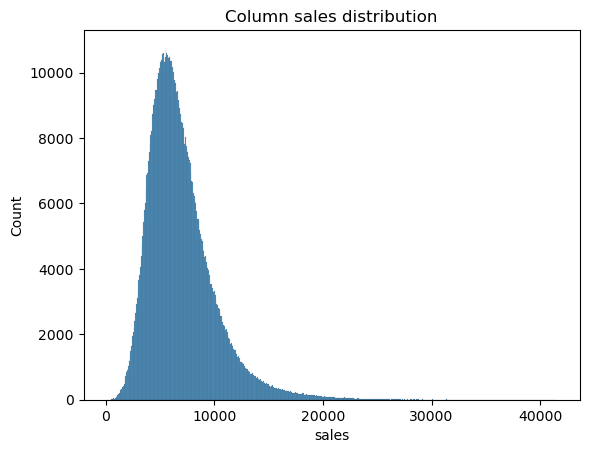

In [26]:
data = tracker.data.copy()
sns.histplot(data['sales'])
plt.title('Column sales distribution');

In [27]:
print('''Sales column has distribution near to a normal distribution.
How the machine learning models handle better with normal distributions, 
its interesting to apply a log function to model the distribution closer to a normal''')

Sales column has distribution near to a normal distribution.
How the machine learning models handle better with normal distributions, 
its interesting to apply a log function to model the distribution closer to a normal


### Reshape

In [36]:
def reshape_sales(data):
    data.loc[:, 'sales'] = np.log1p(data['sales'])
    return data

tracker.track('sales', 'reshape', reshape_sales, 'Reshape column sales to get closer to a normal distribution')

print('Reshaped column sales to get closer to a normal distribution')

Reshaped column sales to get closer to a normal distribution


### #3 Univariated Analysis

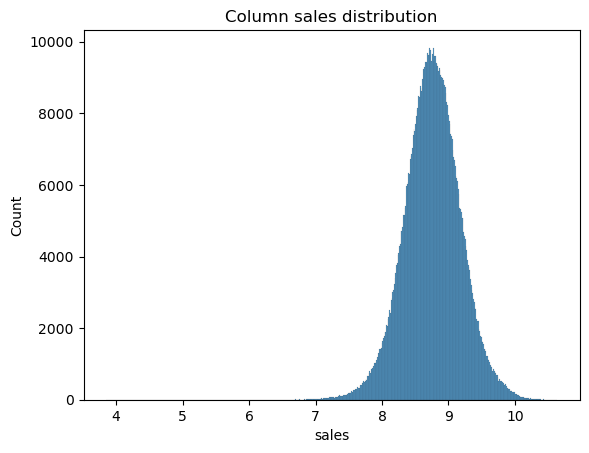

In [37]:
data = tracker.data.copy()
sns.histplot(data['sales'])
plt.title('Column sales distribution');

## store

### Univariated Analysis

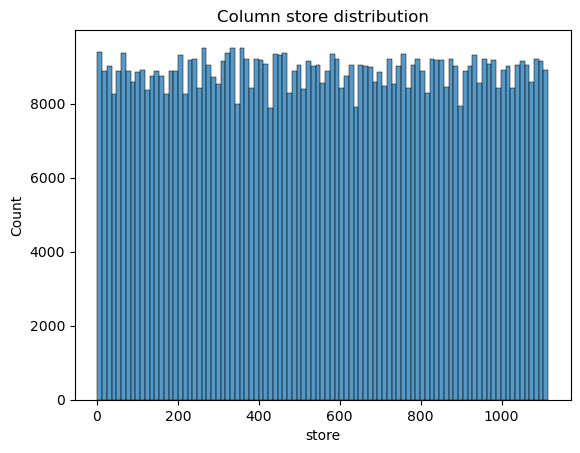

In [38]:
data = tracker.data.copy()

sns.histplot(data['store'])
plt.title('Column store distribution');

In [47]:
print('''There is no pattern in the column store distribution, 
showing that the sales records are well distributed over the stores (balanced data).''')

There is no pattern in the column store distribution, 
showing that the sales records are well distributed over the stores (balanced data).


### Type

In [40]:
data = tracker.data.copy()
if data['store'].dtype == 'int64':
    print("Column store has the right type: int64.")
else:
    print('Please check here.')

Column store has the right type: int64.


### NAs

In [41]:
data = tracker.data.copy()
if (min(data['store'].unique()) > 0) and (sum(data['store'].isna()) == 0):
    print('No NA found.')
else:
    print('Please check here.')
    
print('''
Rules considered to verify the presence of NAs:
1 - NA values
2 - 0 values
''')

No NA found.

Rules considered to verify the presence of NAs:
1 - NA values
2 - 0 values



### Bivariated Analysis

Looking to the variations of sum and mean for the column sales grouped by the column store...


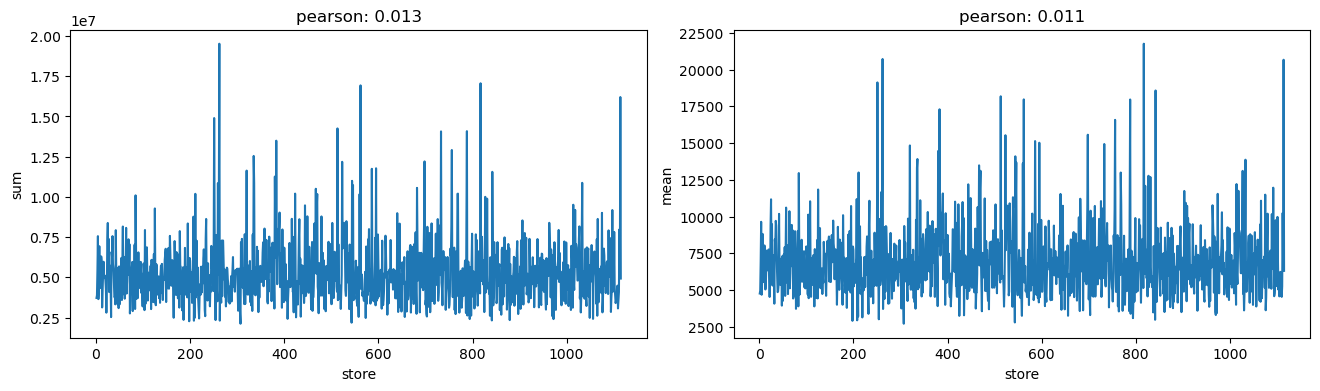

In [42]:
data = tracker.data.copy()
data['sales'] = np.expm1(data['sales']) #returning sales to normal values
data = (data.loc[:, ['store', 'sales']]
            .groupby('store')
            .agg(['sum', 'mean'])
            .droplevel(0, axis=1)
            .reset_index())
pearson_correlations = data.corr(method='pearson')

print('Looking to the variations of sum and mean for the column sales grouped by the column store...')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
sns.lineplot(x=data['store'], y=data['sum'], ax=ax1)
ax1.set_title('pearson: {:.3f}'.format(pearson_correlations.at['store', 'sum']))
sns.lineplot(x=data['store'], y=data['mean'], ax=ax2)
ax2.set_title('pearson: {:.3f}'.format(pearson_correlations.at['store', 'mean']))
fig.subplots_adjust(wspace=0.15)

In [43]:
print('''There is no apparent pattern when correlating store with sales.
Neither Pearson's correlation nor the graphs showed anything.''')

There is no apparent pattern when correlating store with sales.
Neither Pearson's correlation nor the graphs showed anything.


## date

### Type

In [44]:
def retype_date(data):
    data['date'] = pd.to_datetime(data['date'])
    return data

tracker.track('date', 'retype', retype_date, 'Retype column date from object to datetime64[ns]')

print('Retyped column date from object to datetime64[ns]')

Retyped column date from object to datetime64[ns]


### Univariated Analysis

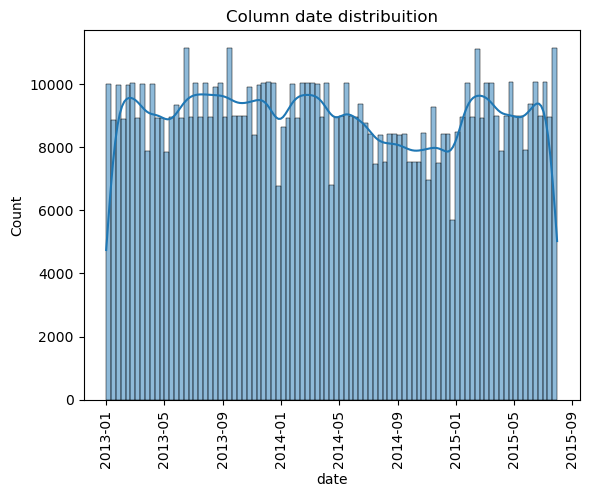

In [64]:
data = tracker.data.copy()

sns.histplot(data['date'], kde=True)
plt.title('Column date distribuition')
plt.xticks(rotation=90);

In [48]:
print('''There is no pattern in the column 'date' distribution, 
showing that the sales records are well distributed over the date (balanced data).''')

There is no pattern in the column 'date' distribution, 
showing that the sales records are well distributed over the date (balanced data).


### Bivariated Analysis

Looking to the variations of sum and mean for the column sales grouped by the column date...


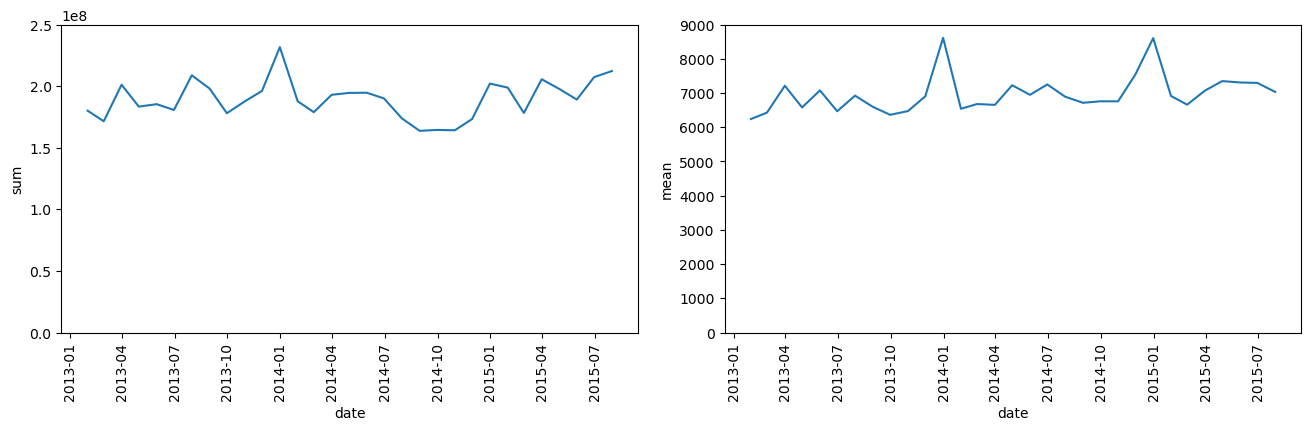

In [87]:
data = tracker.data.copy()
data['sales'] = np.expm1(data['sales']) #returning sales to normal values
data = (data.loc[:, ['date', 'sales']]
            .groupby(pd.Grouper(key='date', freq='M'))
            .agg(['sum', 'mean'])
            .droplevel(0, axis=1)
            .reset_index())
pearson_correlations = data.corr(method='pearson')
print('Looking to the variations of sum and mean for the column sales grouped by the column date...')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
sns.lineplot(x=data['date'], y=data['sum'], ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=90)
ax1.set_ylim([0,250000000])
sns.lineplot(x=data['date'], y=data['mean'], ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=90)
ax2.set_ylim([0,9000])
fig.subplots_adjust(wspace=0.15)

In [88]:
print('''Observing the curves with the sum and mean of sales over time,
it is not possible to point out any pattern referring to the direction of the curve. 
However, there are patterns of peaks at the end/beginning of years.
They will be better analyzed performing the same comparison but using the month or week of the year column (both in numerical mode) as a grouper.''')

Observing the curves with the sum and mean of sales over time,
it is not possible to point out any pattern referring to the direction of the curve. 
However, there are patterns of peaks at the end/beginning of years.
They will be better analyzed performing the same comparison but using the month or week of the year column (both in numerical mode) as a grouper.


### Feature Engneering

## column [MODEL]

### Univariated Analysis

### Rename

### Type

### NAs

### Normalization

### Rescaling

### Encoding

### Nature Transformation

### Bivariated Analysis